# Initialize 

In [33]:
from pupil_apriltags import Detector, Detection
from collections import defaultdict
from typing import List, Dict, Tuple, Any
from glob import glob
import numpy as np
import os
import time
import sys
import cv2
from math import atan2, degrees
import platform
import socket
import matplotlib.pyplot as plt
import math
from statsFuncs import trigonometry as trig
import pandas as pd

In [2]:
ignore = 1

Next cell is all commented out because it's unfeasible to run without overclocking, even so,takes unreasonable amount of time

In [3]:
# #manual_detection.py
# #ignore for use on local machine, unfeasible to run without overclocking, even so, takes unreasonable amount of time


# def extract_frames(video_path: str, frames_path: str) -> None:
#     """Convert a video (mp4 or similar) into a series of individual PNG frames.
#     Make sure to create a directory to store the frames before running this function.
#     Args:
#         video_path (str): filepath to the video being converted
#         frames_path (str): filepath to the target directory that will contain the extract frames
#     """
#     video = cv2.VideoCapture(video_path)
#     count = 0
#     success = 1

#     # Basically just using OpenCV's tools
#     while success:
#         success, frame = video.read()
#         cv2.imwrite(f'{frames_path}/frame{count}.png', frame)
#         count += 1

#     # Optional print statement
#     print(f'Extracted {count} frames from {video_path}.')


# def detect_tags(frames_path: str, aperture=11, visualize=False) -> Tuple[List[List[Dict[str, Any]]], Dict[int, int]]:
#     """Detect all tags (Apriltags3) found in a folder of PNG files and return (1) a list of tag objects
#     for preprocessing and (2) a dictionary containing the frequency that each tag ID appeared
#     Args:n
#         frames_path (str): path to the directory containing PNG images
#         aperture (int):
#         visualize (bool):
#     Returns:
#         frames (List[Dict[str, Any]]): list of objects containing id (int), centroid (np.array[int]) and corners (np.array[int])
#         tag_ds (Dict[int, int]): dictionary mapping tag IDs to frequency of tag across all images
#     """
#     # Initialize variables
#     frames = []
#     tag_ids = defaultdict(int)
#     at_detector = Detector()

#     # Sort by index in.../frame<index>.png
#     all_images = sorted(glob(f'{frames_path}/*.png'), key=lambda f: int(os.path.basename(f)[5:-4]))

#     # Deleted last image after out of range error popped up
#     # TODO: but not analyzing last 2 frames?
#     # Feb 21: commented out deleting last frame, altho this was important when you have all frames in folder
#     print(len(all_images))
#     if len(all_images) > 1:
#         all_images = all_images[:-1]

#     num_images = len(all_images)
#     #print_progress_bar(0, num_images, prefix='Progress:', suffix='Complete', length=50)

#     # Iterate thru all PNG images in frames_path
#     for i, img_path in enumerate(all_images):
#         # Create a grayscale 2D NumPy array for Detector.detect()
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

#         if type(img) == np.ndarray:
#             tags_in_framex = []
#             for tag in at_detector.detect(img):
#                 # Increment frequency
#                 tag_ids[tag.tag_id] += 1
#                 # r = np.roll(np.float32(img), tag.homography + 1, axis=0)
#                 # Add to frames in following format - feel free to adjust
#                 tags_in_framex.append({
#                     'id': tag.tag_id,
#                     'id_confidence': tag.decision_margin,
#                     'soft_id': tag.tag_id,
#                     'perimeter': 100, #cv2.arcLength(img, closed=True),
#                     'centroid': tag.center,
#                     'verts': tag.corners,
#                     'frames_since_true_detection': 0
#                 })

#                 # {'id': msg, 'id_confidence': id_confidence, 'verts': r.tolist(), 'soft_id': soft_msg,
#                 #  'perimeter': cv2.arcLength(r, closed=True), 'centroid': centroid.tolist(),
#                 #  "frames_since_true_detection": 0}
#             frames.append(tags_in_framex)
#         time.sleep(0.01)
#         print_progress_bar(i + 1, num_images, prefix='Progress:', suffix='Complete', length=50)

#     return frames, dict(tag_ids)


def print_progress_bar (iteration, total, prefix ='', suffix ='', decimals = 1, length = 100, fill ='█', printEnd ="\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    sys.stdout.write('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix))
    # Print New Line on Complete
    if iteration == total:
        print()


# def main():
#     # Define path folder
#     if 'Teresa' in socket.gethostname():
#         path = '/Users/teresa/Dropbox/001'
#     else:
#         path = 'C:/Users/hbass/Desktop/SP2020 Research/Subject1/001'
#     # test path from 11/4 recording
#     #path = '/home/whitney/Teresa/demos/2019_11_04/000'
#     # id tag
#     # path = '/home/whitney/recordings/2019_11_01/014'

#     # Create video path
#     video_path = path + "/world.mp4"
#     # Create frame path using OS package
#     # Define the name of the directory to be created
#     frames_path = path + "/frames"
#     try:
#         if not os.path.exists(frames_path):
#             os.mkdir(frames_path)
#         else:
#             print("Successfully created the directory %s " % frames_path)
#     except OSError:
#         print("Creation of the directory %s failed" % frames_path)
#     # Detect tags in frames
#     extract_frames(video_path, frames_path)
#     frames, tag_ids = detect_tags(frames_path)

#     # Descriptive print statements
#     tag_count = sum(count for count in tag_ids.values())
#     print(f'Detected {tag_count} tags in {len(frames)} frames.')
#     print(f'Found IDs of {list(tag_ids.keys())}.')


# if __name__ == '__main__':
#     main()

In [34]:
def detect_tags_test(frames_path: str, aperture=11, visualize=False) -> Tuple[List[List[Dict[str, Any]]], Dict[int, int]]:
    """Detect all tags (Apriltags3) found in a folder of PNG files and return (1) a list of tag objects
    for preprocessing and (2) a dictionary containing the frequency that each tag ID appeared
    Args:n
        frames_path (str): path to the directory containing PNG images
        aperture (int):
        visualize (bool):
    Returns:
        frames (List[Dict[str, Any]]): list of objects containing id (int), centroid (np.array[int]) and corners (np.array[int])
        tag_ds (Dict[int, int]): dictionary mapping tag IDs to frequency of tag across all images
    """
    # Initialize variables
    frames = []
    tag_ids = defaultdict(int)
    at_detector = Detector()

    # Sort by index in.../frame<index>.png
    all_images = sorted(glob(f'{frames_path}/*.png'), key=lambda f: int(os.path.basename(f)[5:-4]))
    print(all_images)
    # Deleted last image after out of range error popped up
    # TODO: but not analyzing last 2 frames?
    # Feb 21: commented out deleting last frame, altho this was important when you have all frames in folder
    print(len(all_images))
    if len(all_images) > 1:
        all_images = all_images[:-1]

    num_images = len(all_images)
    print_progress_bar(0, num_images, prefix='Progress:', suffix='Complete', length=50)

    # Iterate thru all PNG images in frames_path
    for i, img_path in enumerate(all_images):
        # Create a grayscale 2D NumPy array for Detector.detect()
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if type(img) == np.ndarray:
            tags_in_framex = []
            for tag in at_detector.detect(img):
                # Increment frequency
                tag_ids[tag.tag_id] += 1
                # r = np.roll(np.float32(img), tag.homography + 1, axis=0)
                # Add to frames in following format - feel free to adjust
                tags_in_framex.append({
                    'id': tag.tag_id,
                    'id_confidence': tag.decision_margin,
                    'soft_id': tag.tag_id,
                    'perimeter': 100, #cv2.arcLength(img, closed=True),
                    'centroid': tag.center,
                    'verts': tag.corners,
                    'frames_since_true_detection': 0
                })

                # {'id': msg, 'id_confidence': id_confidence, 'verts': r.tolist(), 'soft_id': soft_msg,
                #  'perimeter': cv2.arcLength(r, closed=True), 'centroid': centroid.tolist(),
                #  "frames_since_true_detection": 0}
            frames.append(tags_in_framex)
        time.sleep(0.01)
        print_progress_bar(i + 1, num_images, prefix='Progress:', suffix='Complete', length=50)

    return frames, dict(tag_ids)

# Find center of the screen

First, set path where the frame is in your computer, for now we are going to put it on the main folder of the repository

In [35]:
path = os.getcwd()
path_image = path + '/frame4320.png'

In [36]:
#returns the output of the detect tags on the specific image 4743
frame, tag_ids = detect_tags_test(path)
print(frame[0])

['/Users/teresa/PycharmProjects/serialdependence_radiology/frame4320.png', '/Users/teresa/PycharmProjects/serialdependence_radiology/frame7473.png']
2
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[{'id': 0, 'id_confidence': 106.50772094726562, 'soft_id': 0, 'perimeter': 100, 'centroid': array([374.39699461, 373.78465738]), 'verts': array([[361.09362793, 387.45495605],
       [386.4644165 , 388.21517944],
       [387.75982666, 360.05325317],
       [362.35281372, 359.38192749]]), 'frames_since_true_detection': 0}, {'id': 1, 'id_confidence': 98.80133819580078, 'soft_id': 1, 'perimeter': 100, 'centroid': array([370.0307333 , 498.27567429]), 'verts': array([[357.08108521, 511.13345337],
       [382.84185791, 513.34472656],
       [383.02886963, 485.36975098],
       [357.3828125 , 483.39859009]]), 'frames_since_true_detection': 0}, {'id': 2, 'id_confidence': 104.01153564453125, 'soft_id': 2, 'perimeter': 100, 'centroid': array([371.68976507, 618.31474205])

In [9]:
#function that gets what attribute is of the dictionary generated by detect tags a user needs
#for instance, I needed the centers of each tag and the corners to crop the image, so this function acquires them from the
#return call of detect tags
def attribute(frame, feature):
    qr_codes = frame[0]
    attributes = []
    for i in range(len(qr_codes)):
        qr_code = qr_codes[i]
        print(feature + ' of tag id ' + str(i) + ":", qr_code[feature])
        attributes.append(qr_code[feature])
    return attributes
    

In [10]:
marker_ids = attribute(frame, 'id')

id of tag id 0: 0
id of tag id 1: 1
id of tag id 2: 2
id of tag id 3: 3
id of tag id 4: 5
id of tag id 5: 6
id of tag id 6: 7
id of tag id 7: 8
id of tag id 8: 9
id of tag id 9: 11


In [11]:
print('Total number of markers: ' + str(len(marker_ids)))

Total number of markers: 10


In [12]:
#attains the centers of each QR code of the frame; not sorted in any order
centers = attribute(frame, 'centroid')
#comment for myself: from corners, iterate through and find the corners of highest top left, highest top right, lowest bottom left, lowest bottom right, and then draw a box around the image

centroid of tag id 0: [374.39699461 373.78465738]
centroid of tag id 1: [370.0307333  498.27567429]
centroid of tag id 2: [371.68976507 618.31474205]
centroid of tag id 3: [505.06813157 631.90832722]
centroid of tag id 4: [649.00618041 638.59730662]
centroid of tag id 5: [791.18284252 638.13965165]
centroid of tag id 6: [798.47796993 515.1414722 ]
centroid of tag id 7: [801.71403119 387.27396875]
centroid of tag id 8: [657.41821656 382.65247475]
centroid of tag id 9: [510.51496774 377.87287464]


In [13]:
#attains the corners for each of the QR codes in the frame; not sorted in any order
corners = attribute(frame, 'verts')

verts of tag id 0: [[361.09362793 387.45495605]
 [386.4644165  388.21517944]
 [387.75982666 360.05325317]
 [362.35281372 359.38192749]]
verts of tag id 1: [[357.08108521 511.13345337]
 [382.84185791 513.34472656]
 [383.02886963 485.36975098]
 [357.3828125  483.39859009]]
verts of tag id 2: [[359.77340698 629.82720947]
 [385.00717163 633.19128418]
 [383.76965332 606.64428711]
 [358.44287109 603.51696777]]
verts of tag id 3: [[490.99633789 644.21002197]
 [519.25170898 646.46160889]
 [519.4074707  619.3727417 ]
 [490.72174072 617.18798828]]
verts of tag id 4: [[634.01782227 651.95495605]
 [663.14483643 652.36383057]
 [663.87445068 625.34667969]
 [634.6519165  624.62084961]]
verts of tag id 5: [[776.44903564 651.93164063]
 [803.76361084 650.90826416]
 [806.01739502 624.25335693]
 [778.28845215 625.05273438]]
verts of tag id 6: [[783.81781006 529.63824463]
 [811.64642334 529.53259277]
 [813.17712402 500.60614014]
 [785.22955322 500.66296387]]
verts of tag id 7: [[787.45953369 401.69412231]


(370, 498) (798, 515)


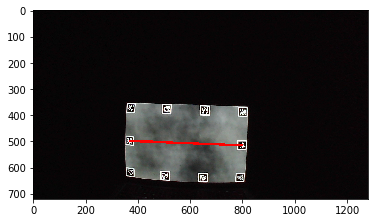

In [14]:
# we need to have a line that goes from marker with tag id 1 and marker with tag id 7
centroid1 = centers[1]
centroid2 = centers[6]
image = cv2.imread(path_image)
window_name = 'Box'
start_point= (int(centroid1[0]),int(centroid1[1]))
end_point = (int(centroid2[0]),int(centroid2[1]))
print(start_point, end_point)
color = (255,0,0)
thickness = 8
image = cv2.line(image, start_point, end_point, color, thickness)
plt.imshow(image)
# cv2.imshow(window_name, image);
# cv2.waitKey(0);

In [15]:
#returns the midpoint between two pixel points, and rounds them to nearest integer for use in drawing programs cv2line/circle
def midpoint(point1, point2):
    return (int((point1[0] + point2[0]) / 2) , int((point1[1] + point2[1]) / 2))

(583, 380) (577, 635)


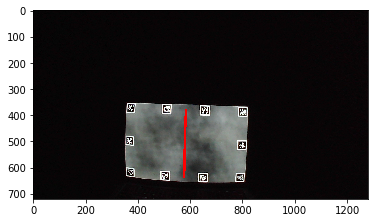

In [16]:
# for the vertical line, the start point is the middle point between marker with id 11 and 9
# and the end point, middle point between marker with id 2 and 5

centroid1 = midpoint(centers[9], centers[8])
centroid2 = midpoint(centers[3], centers[4])
image = cv2.imread(path_image)
window_name = 'Box'
start_point= (int(centroid1[0]),int(centroid1[1]))
end_point = (int(centroid2[0]),int(centroid2[1]))
print(start_point, end_point)
color = (255,0,0)
thickness = 8
image = cv2.line(image, start_point, end_point, color, thickness)
plt.imshow(image)
# cv2.imshow(window_name, image);
# cv2.waitKey(0);

(577, 635) (577, 635)


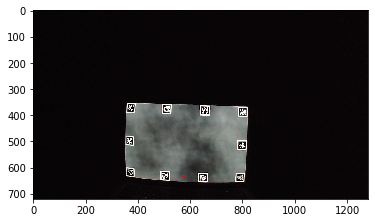

In [17]:
# for the vertical line, the start point is the middle point between marker with id 11 and 9
# and the end point, middle point between marker with id 2 and 5

centroid_vert = midpoint(centers[9], centers[8])
centroid_vert = midpoint(centers[3], centers[4])
image = cv2.imread(path_image)
window_name = 'Box'
start_point_vert= (int(centroid_vert[0]),int(centroid_vert[1]))
end_point_vert = (int(centroid_vert[0]),int(centroid_vert[1]))
print(start_point_vert, end_point_vert)
color = (255,0,0)
thickness = 8
image = cv2.line(image, start_point_vert, end_point_vert, color, thickness)
plt.imshow(image)
# cv2.imshow(window_name, image);
# cv2.waitKey(0);

Ok now that we now how to draw the two lines, lets draw both of them together:

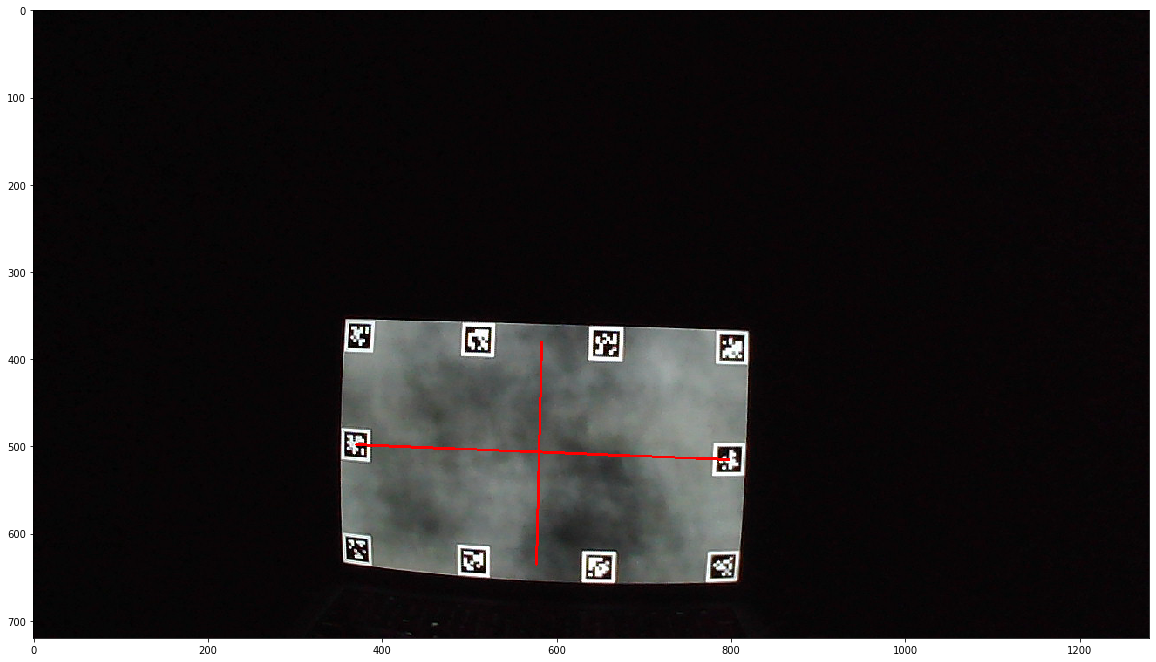

In [18]:
centroid1_hoz = centers[1]
centroid2_hoz = centers[6]
centroid1_vert = midpoint(centers[9], centers[8])
centroid2_vert = midpoint(centers[3], centers[4])

image = cv2.imread(path_image)
window_name = 'Box'
start_point_hoz= (int(centroid1_hoz[0]),int(centroid1_hoz[1]))
end_point_hoz = (int(centroid2_hoz[0]),int(centroid2_hoz[1]))
start_point_vert= (int(centroid1_vert[0]),int(centroid1_vert[1]))
end_point_vert = (int(centroid2_vert[0]),int(centroid2_vert[1]))
color = (255,0,0)
thickness = 2
image = cv2.line(image, start_point_hoz, end_point_hoz, color, thickness)
image = cv2.line(image, start_point_vert, end_point_vert, color, thickness)
plt.figure(figsize=(20,20))
plt.imshow(image)

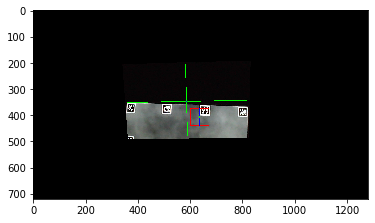

In [19]:
# if not ignore:
#run this cell to generate the XY grid on the specific image 
#optimal points found/masking the image to crop the screen
im = cv2.imread(path_image)
mask = np.zeros(im.shape, dtype=np.uint8)
roi_corners = np.array([[(341,206), (831,193), (825,486), (363,491)]], dtype=np.int32)
channel_count = im.shape[2]
ignore_mask_color = (255,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)
masked_image = cv2.bitwise_and(im, mask)

#corners of the rectangle around the blob
upper_left = (600,375)
upper_right = (672, 375)
bottom_right = (672, 439)
bottom_left = (600, 439)

#drawing code to draw on the cropped image
start_point = (362 ,352)
end_point = (817, 343)
colour = (0,255,0)
thickness = 2
#X-AXIS
masked_image = cv2.line(masked_image, start_point, end_point, colour, thickness)
#Y-AXIS 
top_vert_line = midpoint((666,477), (515, 479))
bot_vert_line = midpoint((662,207), (503,210))
cv2.line(masked_image, top_vert_line, bot_vert_line , colour, thickness)
#ORIGIN
cv2.circle(masked_image, (586, 348), 2, (0,0,255), thickness)
#Testing to box around the blob
cv2.rectangle(masked_image, (600, 375), (672, 439), (255,0,0), thickness)

#center of the blob
cv2.line(masked_image, midpoint(upper_left, bottom_left), midpoint(upper_right, bottom_right), (0,0,255), thickness)
cv2.line(masked_image, midpoint(upper_left, upper_right), midpoint(bottom_left, bottom_right), (0,0,255), thickness)
cv2.circle(masked_image, (636,407), 2, colour, thickness)
plt.imshow(masked_image);
#     cv2.waitKey(1000);
#cv2.imshow('mask',masked_image);
#cv2.imsave('C:/Users/hbass/Desktop/SP2020 Research/Subject1/Subject1/001/frames_selected/masked_image.jpg', masked_image)
#cv2.waitKey(0);


In [20]:
#testing cell to find best fit origin
start_point = (362 ,352)
end_point = (817, 343)
top_vert_line = midpoint((666,477), (515, 479))
bot_vert_line = midpoint((662,207), (503,210))
origin_y = midpoint(top_vert_line, bot_vert_line)
origin_x = midpoint(start_point, end_point)
#found by tuning the values computed above
origin = (586,348)
print(origin)

(586, 348)


# Mask non-screen 

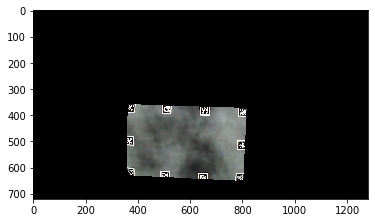

In [21]:
#finding the appropriate permutation of the pixels that crop the screen
bottom_left = 0
bottom_right = 1
upper_right = 2
upper_left = 3
points = [(corners[0][upper_left][0], corners[0][upper_left][1]),
          (corners[2][bottom_left][0], corners[2][bottom_left][1]),
          (corners[5][bottom_right][0], corners[5][bottom_right][1]),
          (corners[7][upper_right][0], corners[7][upper_right][1])]

im = cv2.imread(path_image)
mask = np.zeros(im.shape, dtype=np.uint8)
roi_corners = np.array([[points[0], points[1], points[2], points[3]]], dtype=np.int32)
channel_count = im.shape[2]
ignore_mask_color = (255,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)
masked_image = cv2.bitwise_and(im, mask)
plt.imshow(masked_image);


In [22]:
def make_mask_image(path_image, im):
    #finding the appropriate permutation of the pixels that crop the screen
    bottom_left = 0
    bottom_right = 1
    upper_right = 2
    upper_left = 3
    points = [(corners[0][upper_left][0], corners[0][upper_left][1]),
              (corners[2][bottom_left][0], corners[2][bottom_left][1]),
              (corners[5][bottom_right][0], corners[5][bottom_right][1]),
              (corners[7][upper_right][0], corners[7][upper_right][1])]

    mask = np.zeros(im.shape, dtype=np.uint8)
    roi_corners = np.array([[points[0], points[1], points[2], points[3]]], dtype=np.int32)
    channel_count = im.shape[2]
    ignore_mask_color = (255,)*channel_count
    cv2.fillPoly(mask, roi_corners, ignore_mask_color)
    masked_image = cv2.bitwise_and(im, mask)
    
    return masked_image

Combine mask image and with lines

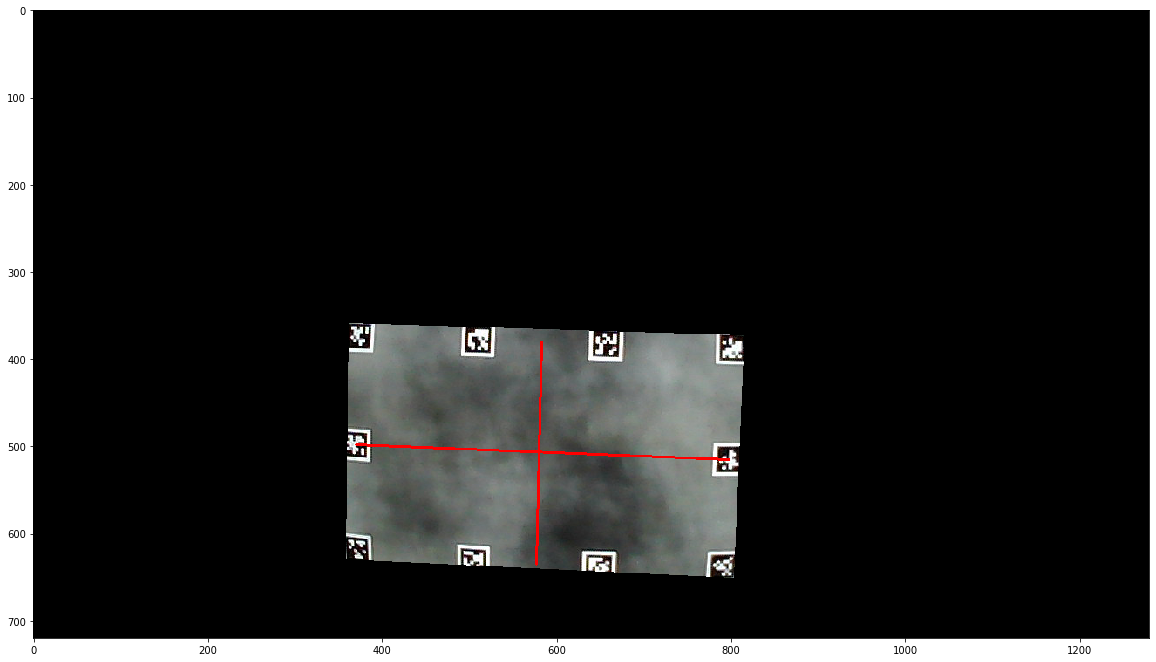

In [23]:
centroid1_hoz = centers[1]
centroid2_hoz = centers[6]
centroid1_vert = midpoint(centers[9], centers[8])
centroid2_vert = midpoint(centers[3], centers[4])

image = cv2.imread(path_image)
window_name = 'Box'
start_point_hoz= (int(centroid1_hoz[0]),int(centroid1_hoz[1]))
end_point_hoz = (int(centroid2_hoz[0]),int(centroid2_hoz[1]))
start_point_vert= (int(centroid1_vert[0]),int(centroid1_vert[1]))
end_point_vert = (int(centroid2_vert[0]),int(centroid2_vert[1]))
color = (255,0,0)
thickness = 2

image = make_mask_image(path_image, image)
image = cv2.line(image, start_point_hoz, end_point_hoz, color, thickness)
image = cv2.line(image, start_point_vert, end_point_vert, color, thickness)

plt.figure(figsize=(20,20))
plt.imshow(image)

# Trigonometry functions 

In [24]:
from __future__ import division 

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

In [25]:
def rect_corners_from_center(center, width, hight):
    centerX = center[0]
    centerY = center[1]
    
    top_left = (int(centerX-width/2), int(centerY-hight/2))
    bottom_right = (int(centerX+width/2), int(centerY+hight/2))
    
    return top_left, bottom_right

In [26]:
def point_in_circle(angle, center_circle):
    radian = angle * 0.0174532925
    x = radius_circle *  math.cos(radian) + center_circle[0]
    y = radius_circle *  -math.sin(radian) + center_circle[1]
    coordinates_blob = (x, y)
    
    return coordinates_blob

# Looking for center of screen 

In [27]:
centroid1_hoz = centers[1]
centroid2_hoz = centers[6]
centroid1_vert = midpoint(centers[9], centers[8])
centroid2_vert = midpoint(centers[3], centers[4])

L1 = line(centroid1_hoz, centroid2_hoz)
L2 = line(centroid1_vert, centroid2_vert)

R = intersection(L1, L2)
if R:
    print("Intersection detected:", R)
else:
    print("No single intersection point detected")

Intersection detected: (580.0225414515197, 506.5419883104109)


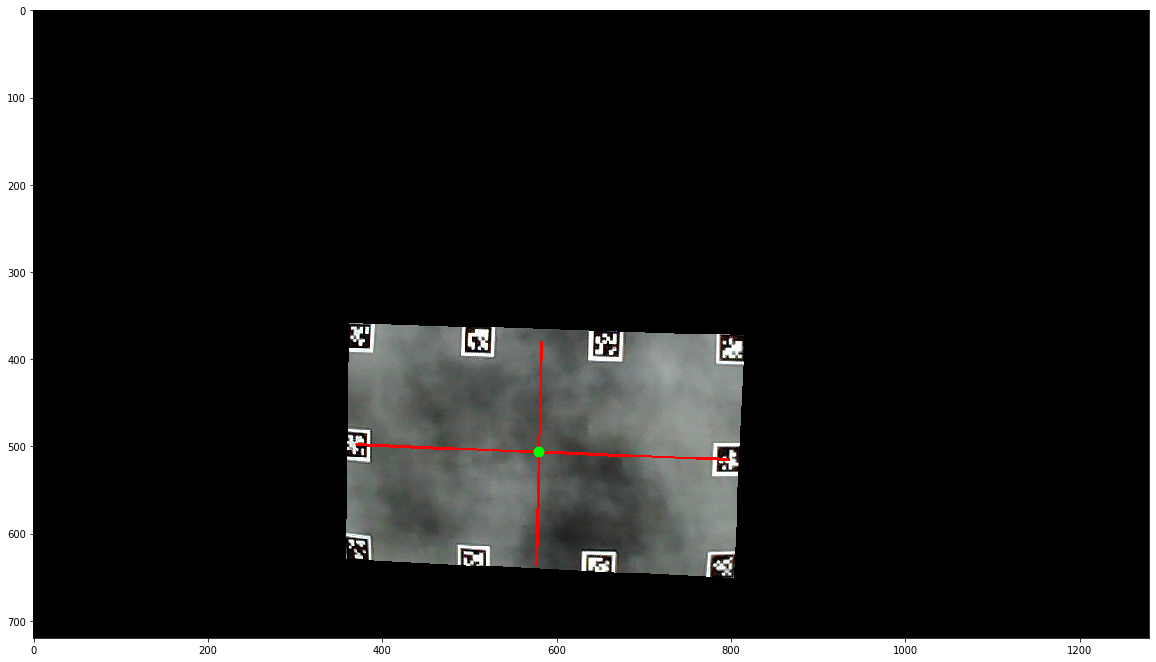

In [28]:
centroid1_hoz = centers[1]
centroid2_hoz = centers[6]
centroid1_vert = midpoint(centers[9], centers[8])
centroid2_vert = midpoint(centers[3], centers[4])
intersection = (int(R[0]), int(R[1]))

image = cv2.imread(path_image)
window_name = 'Box'
start_point_hoz= (int(centroid1_hoz[0]),int(centroid1_hoz[1]))
end_point_hoz = (int(centroid2_hoz[0]),int(centroid2_hoz[1]))
start_point_vert= (int(centroid1_vert[0]),int(centroid1_vert[1]))
end_point_vert = (int(centroid2_vert[0]),int(centroid2_vert[1]))
red = (255,0,0)
green = (0, 255, 0)
thickness = 2

image = make_mask_image(path_image, image)
image = cv2.line(image, start_point_hoz, end_point_hoz, red, thickness) # horizontal line
image = cv2.line(image, start_point_vert, end_point_vert, red, thickness) # vertical line
image = cv2.circle(image, intersection, 2, green, 8) # point in the center of the screen

plt.figure(figsize=(20,20))
plt.imshow(image)

# Find blob 

First we draw a circle of diamater XX around the center. The blob could appear anywhere in that circle

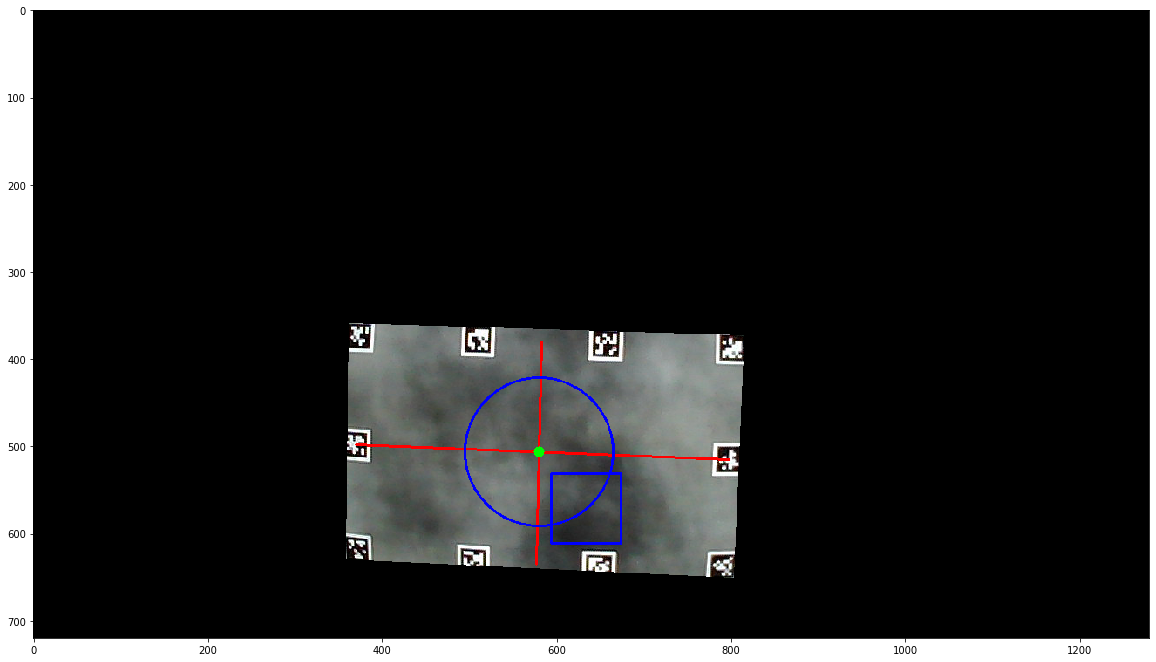

In [29]:

centroid1_hoz = centers[1]
centroid2_hoz = centers[6]
centroid1_vert = midpoint(centers[9], centers[8])
centroid2_vert = midpoint(centers[3], centers[4])
intersection = (int(R[0]), int(R[1]))

image = cv2.imread(path_image)
window_name = 'Box'
start_point_hoz= (int(centroid1_hoz[0]),int(centroid1_hoz[1]))
end_point_hoz = (int(centroid2_hoz[0]),int(centroid2_hoz[1]))
start_point_vert= (int(centroid1_vert[0]),int(centroid1_vert[1]))
end_point_vert = (int(centroid2_vert[0]),int(centroid2_vert[1]))
red = (255,0,0)
blue = (0, 0, 255)
thickness = 2
radius_circle = 85

image = make_mask_image(path_image, image)
image = cv2.line(image, start_point_hoz, end_point_hoz, red, thickness) # horizontal line
image = cv2.line(image, start_point_vert, end_point_vert, red, thickness) # vertical line
image = cv2.circle(image, intersection, 2, green, 8) # point in the center of the screen
image = cv2.circle(image, intersection, radius_circle, blue, 2) # point in the center of the screen


angle = 310
# # draw rectangle
coordinates_blob = trig.point_in_circle(angle, intersection, radius_circle)
top_left, bottom_right = trig.rect_corners_from_center(coordinates_blob, 80, 80)
image = cv2.rectangle(image, top_left, bottom_right, blue, thickness)

# cv2.imshow('rectangle', image);
# cv2.waitKey(0);
plt.figure(figsize=(20,20))
plt.imshow(image)




# Using pixel convertor

In [30]:
#pixel to degree
#TODO: figure out what size_in_px represents
h = 19.65
d = 57.3
r = 1600
size_in_px = 72
deg_per_px = degrees(atan2(.5*h, d)) / (.5*r)
size_in_deg = size_in_px * deg_per_px
print('The size of the stimulus is %s pixels and %s visual degrees' \
    % (size_in_px, size_in_deg))

The size of the stimulus is 72 pixels and 0.8756694059682902 visual degrees


# Input angle 

In [31]:
data = pd.read_csv('S1_AdjustEyeTrack_2019_Dec_03_1223.csv')

FileNotFoundError: [Errno 2] File S1_AdjustEyeTrack_2019_Dec_03_1223.csv does not exist: 'S1_AdjustEyeTrack_2019_Dec_03_1223.csv'

# Ignore 

In [ ]:
#Not needed given bitwise mask below but good reference.
#The drawing of the image generated from the best coordinates from the cell above
#DRAWING HERE
if not ignore:
    path = path_image
    image = cv2.imread(path)
    window_name = 'Box'
    start_point= (341,206)
    end_point = (825, 486)
    color = (255,0,0)
    thickness = 2
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    cv2.imshow(window_name, image);
    cv2.waitKey(0);

In [ ]:
#Not needed anymore since we use a bitwise masking procedure to crop the image. This was done using the
#cv2 rectangle function which requires an upper left and bottom right corner. Keeping for future reference on how to
#use the cv2 rectangle function.

#TESTING FOR OPTIMAL POINT: drawing of the rectangle using cv2, need an upper left and bottom right corner
if not ignore:
    for i in range(len(corners)):
        sq = corners[i]
        for j in range(len(sq)):
            coord = sq[j]
            path = path_image
            image = cv2.imread(path)
            window_name = 'Box'
            start_point= (341,206)
            end_point = (int(coord[0]), int(coord[1]))
            print(end_point)
            color = (255,0,0)
            thickness = 2
            image = cv2.rectangle(image, start_point, end_point, color, thickness)
            cv2.imshow(window_name, image);
            cv2.waitKey(0);

In [ ]:
#Goes through all centroids of the QR codes and generates the lines create the XY grid through the center of the screen.
#When running, hit a button on the keyboard to filter through all combinations until an appropriate one is found.
#Prints out the coordinates that were used.

#Testing lines for appropriate XY grid 
#centroid for xy grid
if not ignore:
    for centroid1 in centers:
        for centroid2 in centers:
            image = cv2.imread(path_image)
            window_name = 'Box'
            start_point= (int(centroid1[0]),int(centroid1[1]))
            end_point = (int(centroid2[0]),int(centroid2[1]))
            print(start_point, end_point)
            color = (255,0,0)
            thickness = 2
            print(image)
            image = cv2.line(image, start_point, end_point, color, thickness)
            cv2.imshow(window_name, image);
            cv2.waitKey(0);
        

In [ ]:
if not ignore:
    #finding the appropriate permutation of the pixels that crop the screen
    points = [(341, 206), (363, 491), (831, 193), (825,486)]
    for i in range(len(points)):
        for j in range(len(points)):
            for k in range(len(points)):
                for n in range(len(points)):
                    im = cv2.imread(path_image)
                    mask = np.zeros(im.shape, dtype=np.uint8)
                    print(points[i], points[j], points[k], points[n])
                    roi_corners = np.array([[points[i], points[j], points[k], points[n]]], dtype=np.int32)
                    channel_count = im.shape[2]
                    ignore_mask_color = (255,)*channel_count
                    cv2.fillPoly(mask, roi_corners, ignore_mask_color)
                    masked_image = cv2.bitwise_and(im, mask)
                    cv2.imshow('masked', masked_image);
                    cv2.waitKey(0);

In [ ]:
if not ignore:
#Since the ROI_CORNERS parameter of the masking requires a specific ordering to crop the image, we need to find
#the best permutation of the coordinates calculated from before to generate the image we need
#Hit a button on the keyboard to filter through the images.
#Prints out coordinate.

    #finding the appropriate permutation of the pixels that crop the screen
    points = [(341, 206), (363, 491), (831, 193), (825,486)]
    for i in range(len(points)):
        for j in range(len(points)):
            for k in range(len(points)):
                for n in range(len(points)):
                    im = cv2.imread(path_image)
                    mask = np.zeros(im.shape, dtype=np.uint8)
                    print(points[i], points[j], points[k], points[n])
                    roi_corners = np.array([[points[i], points[j], points[k], points[n]]], dtype=np.int32)
                    channel_count = im.shape[2]
                    ignore_mask_color = (255,)*channel_count
                    cv2.fillPoly(mask, roi_corners, ignore_mask_color)
                    masked_image = cv2.bitwise_and(im, mask)
                    cv2.imshow('masked', masked_image);
                    cv2.waitKey(0);

In [ ]:
if not ignore:
    #Bitwise masking that crops the image based on just what we want to see on the screen. Utilzes the corner
    #coordiates from previous cell computations, and then filters through to see which is the best mask.
    #Hit a keyboard button to filter through images.

    #Testing for the cropping of the mask image 
    for i in range(len(corners)):
        sq = corners[i]
        for j in range(len(sq)):
            coord = sq[j]
            x = int(coord[0])
            y = int(coord[1])
            print(x,y)
            im = cv2.imread(path_image)
            mask = np.zeros(im.shape, dtype=np.uint8)
            roi_corners = np.array([[(341, 206), (x,y), (831, 193), (825,486)]], dtype=np.int32)
            channel_count = im.shape[2]
            ignore_mask_color = (255,)*channel_count
            cv2.fillPoly(mask, roi_corners, ignore_mask_color)
            masked_image = cv2.bitwise_and(im, mask)
            cv2.imshow('masked', masked_image);
            cv2.waitKey(0);